In [1]:
import pandas as pd 
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
import networkx as nx
import sys

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import DistanceMetric
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from matplotlib import rcParams, cycler
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df_csv = pd.read_csv("mp_samples.csv")
df_csv_data = df_csv.iloc[:, 2:2971]
df_graph = pd.read_csv("graph.csv")
df_csv_data2 = df_csv_data.loc[:,(df_csv_data.mean() >= 100)]
df_csv_data2.shape

(48, 20)

In [4]:
def pca_from_df(df):
    '''
    Function processes the data using Principal component analysis(PCA)
    Args:
        df : Dataframe 
    Returns dataframe containing rincipal component of df
    '''
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_normalized = normalize(df_scaled)
    df_normalized = pd.DataFrame(df_normalized)
    
    pca = PCA(n_components = 2)
    df_pca = pca.fit_transform(df_normalized)
    df_pca = pd.DataFrame(df_pca)
    df_pca.columns = ['P1', 'P2']
    
    return df_pca

In [5]:
df_pca = pca_from_df(df_csv_data2)
df_pca.index = df_csv['Patients']
df_pca['class_label'] = ['CD' if 'CD' in index else 'UC' if 'UC' in  index else 'C' for index, patient in df_pca.iterrows()]
df_pca['class_label'] = df_pca['class_label'].astype('category').cat.codes
df_pca_control = df_pca[['P1','P2']]

In [21]:
def get_graph(df, proximity_measure) :
    '''
    Function to create graph
    Args:
        df: Dataframe
        proximity_measure = Distance measure
    Returns graph of df
    '''
    dist = DistanceMetric.get_metric(proximity_measure)
    matrix_dist = dist.pairwise(df.to_numpy())
    graph = nx.from_numpy_matrix(matrix_dist)
    
    return graph

##########################################################################################

def adjacency_and_degree_matrix_NJW(df, sigma, proximity_measure):
    '''
    Function to get adjacency and degree matrix using equation proposed by NJW algorithm
    Args:
        df: Dataframe
        sigma: local scaling parameter
        proximity_measure = distance measures
    Returns matrices containing adjacency and degree values
    '''
    dimension = df.shape[0]
    
    adjacency_matrix = np.zeros([dimension, dimension])
    
    dist = iter(pdist(df, metric=proximity_measure))

    for i in range(dimension):
        for j in range(i+1, dimension):
            d = np.exp(-1 * next(dist) ** 2 / (2 * sigma ** 2))
            adjacency_matrix[i,j] = d
            adjacency_matrix[j,i] = d
            
#     degrees = []
#     degree_matrix = np.zeros([dimension, dimension])
    
#     for row in adjacency_matrix:
#         degrees.append(np.count_nonzero(row))
            
#     np.fill_diagonal(degree_matrix, degrees)
    
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
            
    return adjacency_matrix, degree_matrix

###########################################################################################

def calculate_eigen(degree_matrix,adjacency_matrix, k):
    '''
    Function to get degree matrix and normalized laplacian matrix
    Args:
        degree_matrix : matrix containing degree of each point
        adjacency_matrix: adjacency matrix of the input data. 
    Returns normalized Laplacian matrix 
    '''
    
    # laplacian_matrix = degree_matrix - adjacency_matrix
    
    # Normalized laplacian matrix
    d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
    laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)
    
    e, v = np.linalg.eigh(laplacian_matrix_normalized)
    X = v[:, -1*k:]
    
    row_sums = X.sum(axis=1)
    Y = X / row_sums[:, np.newaxis]
    
    return X, Y

############################################################################################

def cluster_plots(df_pca_labelled, data, algorithm, k):
    
    df_temp = df_pca_labelled[['P1', 'P2']]
    
    df_pca_labelled['cluster'] = algorithm(n_clusters=k).fit_predict(data)
    
    rcParams['figure.figsize']= 12,4

    plt.subplot(1,3,1)
    plot1a = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="class_label", palette="tab10", s=80, legend=False)
    plot1a.set_title('class labels')

    plt.subplot(1,3,2)
    plot1b = sns.scatterplot(data=df_pca_labelled, x="P1", y="P2", hue="cluster", palette="tab10", s=80, legend=False)
    plot1b.set_title('cluster labels')

    matrix = confusion_matrix(df_pca_labelled.class_label, df_pca_labelled.cluster)
    plt.subplot(1,3,3)
    plot2 = sns.heatmap(matrix, annot=True, cmap="tab10")
    plot2.set(xlabel='Clustering Label', ylabel='Class Label')

    plt.tight_layout()

In [27]:
adj_mat, deg_mat = adjacency_and_degree_matrix_NJW(df_pca_control, 0.5, 'euclidean' )


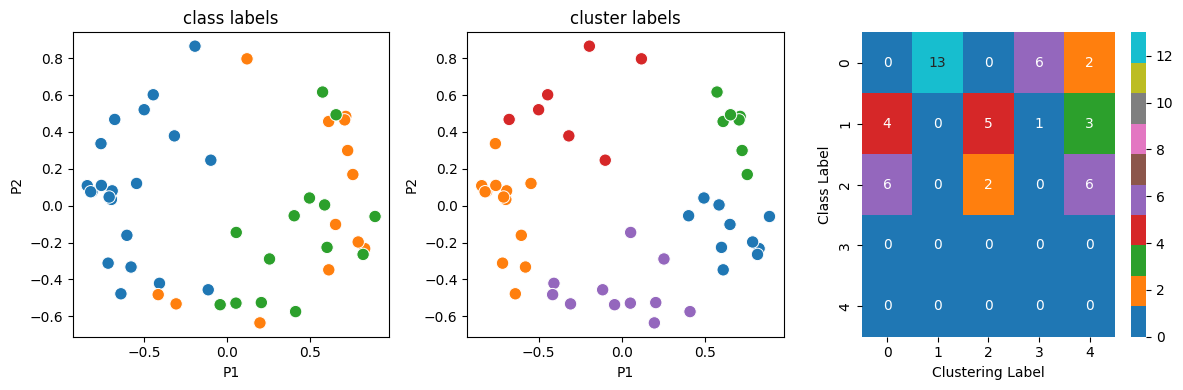

In [31]:
X,Y = calculate_eigen(deg_mat, adj_mat, 5)
cluster_plots(df_pca, X, KMeans, 5)

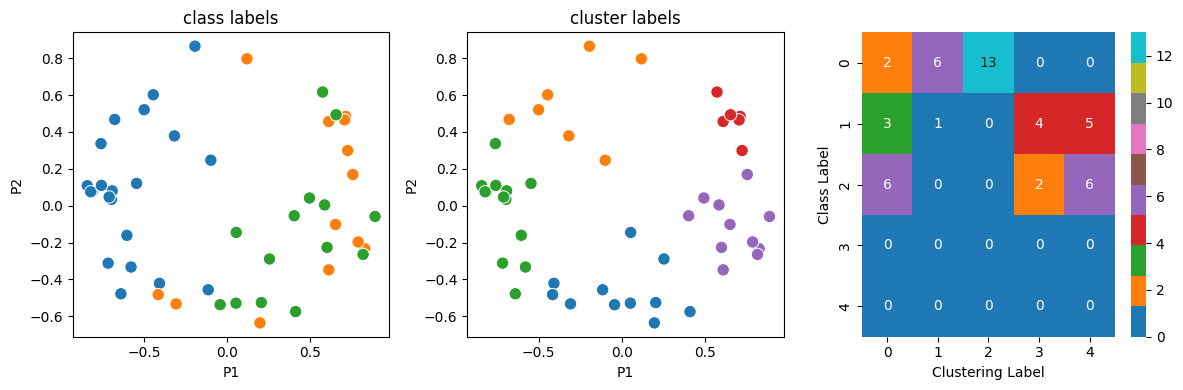

In [32]:
cluster_plots(df_pca, df_pca[['P1','P2']], SpectralClustering, 5)

In [ ]:
def silhouette_coefficient(df):
    '''
    Function to measure silhouette_coefficient 
    Args:
        df : Dataframe  
        
    '''
    range_param = [2,3,4,5,6,7]
    optics_range_param = []
    
    silhouette_avg_kmeans = []
    silhouette_avg_optics = []
    silhouette_avg_agg = []
    silhouette_avg_spec = []
    
    for value in range_param:
        kmeans = KMeans(n_clusters = value)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_  
        silhouette_avg_kmeans.append(silhouette_score(df, cluster_labels))
        
    for value in range_param:
        optics = OPTICS(min_samples = value)
        optics.fit(df)
        cluster_labels = optics.labels_
        optics_range_param.append(len(optics.cluster_hierarchy_))
        silhouette_avg_optics.append(silhouette_score(df, cluster_labels))
        
    for value in range_param:
        agg = AgglomerativeClustering(n_clusters = value)
        agg.fit(df)
        cluster_labels = agg.labels_  
        silhouette_avg_agg.append(silhouette_score(df, cluster_labels))
        
    for value in range_param:
        spec = SpectralClustering(n_clusters = value)
        spec.fit(df)
        cluster_labels = spec.labels_  
        silhouette_avg_spec.append(silhouette_score(df, cluster_labels))
        

    # Parameters for Manual tuning of the graph
    rcParams['figure.figsize']= 10,3

    thisdict_kmeans = dict(zip(range_param,silhouette_avg_kmeans))
    opt_val_kmeans = max(thisdict_kmeans, key = (lambda k: thisdict_kmeans[k]))
    print(f' Optimal number of clusters (kmeans) : {opt_val_kmeans, thisdict_kmeans[opt_val_kmeans]}')
    plt.subplot(1,4,1)
    plt.plot(range_param,silhouette_avg_kmeans,'-bx')
    plt.xlabel('n_clusters') 
    plt.ylabel('kmeans') 
    
    thisdict_optics = dict(zip(range_param,silhouette_avg_optics))
    opt_val_optics = max(thisdict_optics, key = (lambda k: thisdict_optics[k]))
    print(f' Optimal number of clusters (optics) : {opt_val_optics, thisdict_optics[opt_val_optics]}')
    plt.subplot(1,4,2)
    plt.plot(range_param,silhouette_avg_optics,'-bx')
    plt.xlabel('min_samples')
    plt.ylabel('OPTICS') 
    
    thisdict_agg = dict(zip(range_param,silhouette_avg_agg))
    opt_val_agg = max(thisdict_agg, key = (lambda k: thisdict_agg[k]))
    print(f' Optimal number of clusters (agglomerative) : {opt_val_agg, thisdict_agg[opt_val_agg]}')
    plt.subplot(1,4,3)
    plt.plot(range_param,silhouette_avg_agg,'-bx')
    plt.xlabel('n_clusters')
    plt.ylabel('agglomerative')
    
    thisdict_spec = dict(zip(range_param,silhouette_avg_spec))
    opt_val_spec = max(thisdict_spec, key = (lambda k: thisdict_spec[k]))
    print(f' Optimal number of clusters (spectral) : {opt_val_spec, thisdict_spec[opt_val_spec]}')
    plt.subplot(1,4,4)
    plt.plot(range_param,silhouette_avg_spec,'-bx')
    plt.xlabel('n_clusters')
    plt.ylabel('spectral') 
    
    plt.tight_layout()
    plt.show()

In [ ]:
silhouette_coefficient(df_csv_data)
silhouette_coefficient(df_pca)
silhouette_coefficient(U)

In [ ]:
U = np.array(v[:, i[0]]).reshape(-1, 1)

In [ ]:
range_param = [2,3,4,5,6,7]
algorithms = [KMeans]
df_csv_data.name = 'Original'
df_pca.name = 'PCA'
df_U.name = 'Eigen'

list_df = [df_csv_data, df_pca, df_U]

rcParams['figure.figsize']= 5.5,1.5
for df in list_df:
    
    silhouette_values = []
    
    if df.equals(df_U):
        df_temp = U
    else:
        df_temp = df
        
    for value in range_param:
        clustering = SpectralClustering(n_clusters = value)
        # df['cluster']  = clustering.fit_predict(U)
        clustering.fit(df_temp)
        cluster_labels = clustering.labels_  
        silhouette_values.append(silhouette_score(df_csv_data, cluster_labels))

    thisdict = dict(zip(range_param,silhouette_values))
    opt_val = max(thisdict, key = (lambda k: thisdict[k]))
    print(f' {df.name} (optimal value, highest silhouette): {opt_val, thisdict[opt_val]}')
    plt.plot(range_param,silhouette_values,'-bx')
    plt.annotate(f'{df.name}', xy = (opt_val-0.2,thisdict[opt_val]-0.08))
    plt.title(f'{clustering.__class__.__name__}')


In [ ]:
# Kmeans Clustering
def kmeans(df, n):
    """Function to perform kmeans
    Args:
        df (dataframe): dataframe of points to be clustered
        n (integer): number of clusters
    """
    kmeans = KMeans(n_clusters=n)
    df['cluster'] = kmeans.fit_predict(df)

    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]

    df['cen_x'] = df.cluster.map({i:cen_x[i] for i in range(n)})
    df['cen_y'] = df.cluster.map({i:cen_x[i] for i in range(n)})

 
    plot = sns.scatterplot(data=df,x="P1",y="P2",hue=df['cluster'])
    
    return df, plot  

In [ ]:
def OPTICS(df,n):
    """Function to perform kmeans
    Args:
        df (dataframe): dataframe of points to be clustered
        n (integer): min number of point to form a cluster
    """
    optics = OPTICS(min_samples = n).fit(df)
    
    df['cluster'] = optics.labels_
    
    plot = sns.scatterplot(data=df,x="PC1",y="PC2",hue=df['cluster'])
    
    return df,plot